In [ ]:
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Name: Jonah Zembower
# Date: March 1, 2025
# Project: EY 2025 Data Science Challenge
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

# Loading Libraries and Data:

Importing the necessary libraries:

In [ ]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Import common librabries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For the elevation data
from scipy.spatial import cKDTree

# For the geodataframe
import geopandas as gpd
from shapely import wkt

Importing the necessary datasets:

In [118]:
# Loading in the datasets regarding elevation, shoreline, and zip codes
zip_code = pd.read_csv("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\New York Open Source Data\\POST_OFFICE.csv")
shoreline = pd.read_csv("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\New York Open Source Data\\NYC_Planimetric_Database__Shoreline_20250225.csv")
elevation = pd.read_csv('C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\New York Open Source Data\\Building_Elevation_and_Subgrade__BES__20250225.csv')
elevation_2 = pd.read_csv("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\NYC_Planimetric_Database__Elevation_Points_20250301.csv")
city_map = pd.read_csv("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\New York Open Source Data\\DCM_StreetNameChanges_Points_20250225.csv")

In [ ]:
# Planimetric Clusters:
roadbed_clusters = pd.read_csv("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\Planimetric Database\\Roadbed_Coord_Clusters.csv")
elevation_clusters = pd.read_csv("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\Planimetric Database\\Elevation_Clusters.csv")
shoreline_clusters = pd.read_csv("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\Planimetric Database\\Shoreline_Clusters.csv")
park_clusters = pd.read_csv("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\Planimetric Database\\Park_Clusters.csv")

In [119]:
# Loading in the demographic data
bronx_boroughs = pd.read_csv("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\bronx_boroughs.csv")
manhattan_boroughs = pd.read_csv("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\manhattan_boroughs.csv")
# Loading in the economic data
economic_bronx = pd.read_excel("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\Bronx_economic.xlsx")
economic_manhattan = pd.read_excel("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\Manhattan_economic.xlsx")

# Data Cleaning:

### Geographic Data:

Establishing the bounds for the data:

In [120]:
# The region that is boudning the city into the bronx and manhattan locations
lower_left = (40.75, -74.01)
upper_right = (40.88, -73.86)
# bounds = (min_lon, min_lat, max_lon, max_lat)
bounds = (lower_left[1], lower_left[0], upper_right[1], upper_right[0])

Filtering the data for the region that we are looking at:

In [121]:
# Define the bounding box
min_lat, min_lon = lower_left
max_lat, max_lon = upper_right

# Convert the_geom to a GeoDataFrame
zip_code['geometry'] = zip_code['the_geom'].apply(wkt.loads)
gdf_geometry = gpd.GeoDataFrame(zip_code, geometry='geometry')

# Filter the zip_code data points within the bounding box
filtered_zip_code = zip_code[
    (zip_code['geometry'].apply(lambda geom: geom.y) >= min_lat) &
    (zip_code['geometry'].apply(lambda geom: geom.y) <= max_lat) &
    (zip_code['geometry'].apply(lambda geom: geom.x) >= min_lon) &
    (zip_code['geometry'].apply(lambda geom: geom.x) <= max_lon)
]

# Convert the_geom to a GeoDataFrame
shoreline['geometry'] = shoreline['the_geom'].apply(wkt.loads)
gdf_geometry = gpd.GeoDataFrame(shoreline, geometry='geometry')

# Filter the shoreline data points within the bounding box
filtered_shoreline = shoreline[
    (shoreline['geometry'].apply(lambda geom: geom.bounds[1]) >= min_lat) &
    (shoreline['geometry'].apply(lambda geom: geom.bounds[3]) <= max_lat) &
    (shoreline['geometry'].apply(lambda geom: geom.bounds[0]) >= min_lon) &
    (shoreline['geometry'].apply(lambda geom: geom.bounds[2]) <= max_lon)
]

# Convert the elevation_2['Elevation'] column to meters instead of feet
elevation['z_grade'] = elevation['z_grade'] * 0.328084

# Convert the_geom to a GeoDataFrame
elevation['geometry'] = elevation['the_geom'].apply(wkt.loads)
gdf_geometry = gpd.GeoDataFrame(elevation, geometry='geometry')

# Filter the elevation data points within the bounding box
filtered_elevation = elevation[
    (elevation['latitude'] >= min_lat) &
    (elevation['latitude'] <= max_lat) &
    (elevation['longitude'] >= min_lon) &
    (elevation['longitude'] <= max_lon)
]

# Convert the_geom to a GeoDataFrame
elevation_2['geometry'] = elevation_2['the_geom'].apply(wkt.loads)
gdf_geometry = gpd.GeoDataFrame(elevation_2, geometry='geometry')

# Filter the elevation_2 data points within the bounding box
filtered_elevation_2 = elevation_2[
    (elevation_2['geometry'].apply(lambda geom: geom.y) >= min_lat) &
    (elevation_2['geometry'].apply(lambda geom: geom.y) <= max_lat) &
    (elevation_2['geometry'].apply(lambda geom: geom.x) >= min_lon) &
    (elevation_2['geometry'].apply(lambda geom: geom.x) <= max_lon)
]

# Convert the elevation_2['Elevation'] column to meters instead of feet
filtered_elevation_2['ELEVATION'] = filtered_elevation_2['ELEVATION'] * 0.328084

# Convert the_geom to a GeoDataFrame
city_map['geometry'] = city_map['the_geom'].apply(wkt.loads)
gdf_geometry = gpd.GeoDataFrame(city_map, geometry='geometry')

# Filter the city_map data points within the bounding box
filtered_city_map = city_map[
    (city_map['geometry'].apply(lambda geom: geom.y) >= min_lat) &
    (city_map['geometry'].apply(lambda geom: geom.y) <= max_lat) &
    (city_map['geometry'].apply(lambda geom: geom.x) >= min_lon) &
    (city_map['geometry'].apply(lambda geom: geom.x) <= max_lon)
]

Difference the elevation data appropriately from the z_grade and the total height from the planimetric data:

In [122]:
# Extract coordinates from filtered_elevation and filtered_elevation_2_building
coords_elevation = np.array(list(zip(filtered_elevation['longitude'], filtered_elevation['latitude'])))
coords_elevation_2 = np.array(list(zip(filtered_elevation_2['geometry'].apply(lambda geom: geom.x), filtered_elevation_2['geometry'].apply(lambda geom: geom.y))))

# Create a KDTree for filtered_elevation_2_building
tree_elevation_2 = cKDTree(coords_elevation_2)

# Query the KDTree to find the nearest neighbors in filtered_elevation_2_building for each point in filtered_elevation
distances, indices = tree_elevation_2.query(coords_elevation, k=1)

# Compute the difference in elevation
elevation_difference = filtered_elevation_2.iloc[indices]['ELEVATION'].values - filtered_elevation['z_grade'].values

# Create a new dataframe with the required columns
elevation_df = pd.DataFrame({
    'longitude': filtered_elevation['longitude'],
    'latitude': filtered_elevation['latitude'],
    'z_grade': filtered_elevation['z_grade'],
    'Total Elevation': filtered_elevation_2['ELEVATION'].values[indices],
    'Actual Elevation': elevation_difference,
    'Feat_Code': filtered_elevation_2.iloc[indices]['FEAT_CODE'].values
})

# Display the new dataframe
elevation_df.head()

,longitude,latitude,z_grade,Total Elevation,Actual Elevation,Feat_Code
25,-73.930310,40.754337,13.840880,25.827324,11.986444,3020
26,-73.926556,40.756115,14.684056,24.318522,9.634467,3020
29,-73.944877,40.809825,8.923229,22.087472,13.164243,3020
30,-73.941198,40.808671,7.995735,28.066493,20.070757,3020
33,-73.911906,40.822514,9.902231,43.235523,33.333292,3020


In [123]:
# Filter the data to only include instances where FEAT_CODE is 3020 for buildings
elevation_df_building = elevation_df[elevation_df['Feat_Code'] == 3020]
# Filter the data to only include instances where FEAT_CODE is 3010 for water
filtered_elevation_2_water = filtered_elevation_2[filtered_elevation_2['FEAT_CODE'] == 3010]
# Filter the data to only include instances where FEAT_CODE is 3000 for Spot/Bridge
filtered_elevation_2_bridge = filtered_elevation_2[filtered_elevation_2['FEAT_CODE'] == 3000]

Here are the majority datasets:
- filtered_zip_code: This includes the stations and where they are located in our region of interest using zip codes.
- filtered_shoreline: This includes the location of the shoreline given longitude and latitude.
- filtered_elevation: This gives the grade starting point of elevation that every building is at.
- filtered_elevation_2: This includes the planimetric data that houses the total elevation for buildings, water, bridges, and more.
- filtered_city_map: This showcases the interesections, corners, and squares along with where they are located in our region. 
- elevation_df: This includes the difference that gives the actual elevation of a building.
- elevation_df_building: This specifies to only select buildings.
- filtered_elevation_2_water: This specifies to only select the elevation of water that is found from the planimeric data.
- filtered_elevation_2_bridge: This specifies to only select the elevatino of bridges and others that is found from the planimetric data.

### Socioeconomic Data

In [124]:
# Define the demographic column names
Sex_Age = ['Male','Female','Under 5 years','5 to 9 years','10 to 14 years','15 to 19 years','20 to 24 years','25 to 34 years','35 to 44 years','45 to 54 years','55 to 59 years','60 to 64 years','65 to 74 years','75 to 84 years','85 years and over','Median age (years)']
Race = ['White','Black or African American','American Indian and Alaska Native','Cherokee tribal grouping','Chippewa tribal grouping','Navajo tribal grouping','Sioux tribal grouping','Asian','Asian Indian','Chinese','Filipino','Japanese','Korean','Vietnamese','Other Asian','Native Hawaiian and Other Pacific Islander','Native Hawaiian','Guamanian or Chamorro','Samoan','Other Pacific Islander','Some other race','Hispanic or Latino (of any race)','Mexican','Puerto Rican','Cuban','Other Hispanic or Latino']
Housing = ['Total housing units']
Citizen = ['Citizen, 18 and over population']
Population = ['Total population']

In [125]:
# Define the economic column names
employment_status = ['Population 16 years and over','In labor force','Civilian labor force','Employed','Unemployed','Armed Forces','Not in labor force','Civilian labor force']
commuting_status = ['Workers 16 years and over','Car, truck, or van -- drove alone','Car, truck, or van -- carpooled','Public transportation (excluding taxicab)','Walked','Other means','Worked from home','Mean travel time to work (minutes)']
occupation_status = ['Civilian employed population 16 years and over','Management, business, science, and arts occupations','Service occupations','Sales and office occupations','Natural resources, construction, and maintenance occupations','Production, transportation, and material moving occupations']
industry_status = ['Civilian employed population 16 years and over','Agriculture, forestry, fishing and hunting, and mining','Construction','Manufacturing','Wholesale trade','Retail trade','Transportation and warehousing, and utilities','Information','Finance and insurance, and real estate and rental and leasing','Professional, scientific, and management, and administrative and waste management services','Educational services, and health care and social assistance','Arts, entertainment, and recreation, and accommodation and food services','Other services, except public administration','Public administration']
class_workers = ['Civilian employed population 16 years and over','Private wage and salary workers','Government workers','Self-employed in own not incorporated business workers','Unpaid family workers']
income_benefits = ['Total households','Less than $10,000','$10,000 to $14,999','$15,000 to $24,999','$25,000 to $34,999','$35,000 to $49,999','$50,000 to $74,999','$75,000 to $99,999','$100,000 to $149,999','$150,000 to $199,999','$200,000 or more','Median household income (dollars)','Mean household income (dollars)','With earnings','Mean earnings (dollars)','With Social Security','Mean Social Security income (dollars)','With Supplemental Security Income','Mean Supplemental Security Income (dollars)','With cash public assistance income','Mean cash public assistance income (dollars)','With Food Stamp/SNAP benefits in the past 12 months']
health_insurance = ['Civilian noninstitutionalized population','With health insurance coverage','With private health insurance','With public coverage','No health insurance coverage']

In [126]:
# Split data into the different columns
bronx_employment_status = economic_bronx[employment_status]
bronx_commuting_status = economic_bronx[commuting_status]
bronx_occupation_status = economic_bronx[occupation_status]
bronx_industry_status = economic_bronx[industry_status]
bronx_class_workers = economic_bronx[class_workers]
bronx_income_benefits = economic_bronx[income_benefits]
bronx_health_insurance = economic_bronx[health_insurance]
manhattan_employment_status = economic_manhattan[employment_status]
manhattan_commuting_status = economic_manhattan[commuting_status]
manhattan_occupation_status = economic_manhattan[occupation_status]
manhattan_industry_status = economic_manhattan[industry_status]
manhattan_class_workers = economic_manhattan[class_workers]
manhattan_income_benefits = economic_manhattan[income_benefits]
manhattan_health_insurance = economic_manhattan[health_insurance]

In [127]:
# Split the data into the different columns
bronx_sex_age = bronx_boroughs[Sex_Age]
bronx_race = bronx_boroughs[Race]
bronx_housing = bronx_boroughs[Housing]
bronx_citizen = bronx_boroughs[Citizen]
bronx_population = bronx_boroughs[Population]
manhattan_sex_age = manhattan_boroughs[Sex_Age]
manhattan_race = manhattan_boroughs[Race]
manhattan_housing = manhattan_boroughs[Housing]
manhattan_citizen = manhattan_boroughs[Citizen]
manhattan_population = manhattan_boroughs[Population]

# EDA

### Demographic Data:

First, begin by plotting the relevant data for the different column types on a bar graph.

In [128]:
def plot_distribution(bronx_data, manhattan_data, title):
    fig, ax = plt.subplots(figsize=(14, 8))
    # Define the width of the bars
    bar_width = 0.4

    # Define the positions of the bars
    r1 = np.arange(len(bronx_data.columns))
    r2 = [x + bar_width for x in r1]

    # Plot Bronx data
    ax.bar(r1, bronx_data.iloc[0], width=bar_width, color='blue', label='Bronx')

    # Plot Manhattan data
    ax.bar(r2, manhattan_data.iloc[0], width=bar_width, color='orange', label='Manhattan')

    # Set the position of the x ticks
    ax.set_xticks([r + bar_width / 2 for r in range(len(bronx_data.columns))])
    ax.set_xticklabels(bronx_data.columns)

    # Set labels and title
    ax.set_xlabel('Categories')
    ax.set_ylabel('Units')
    ax.set_title(title)
    ax.legend()

    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

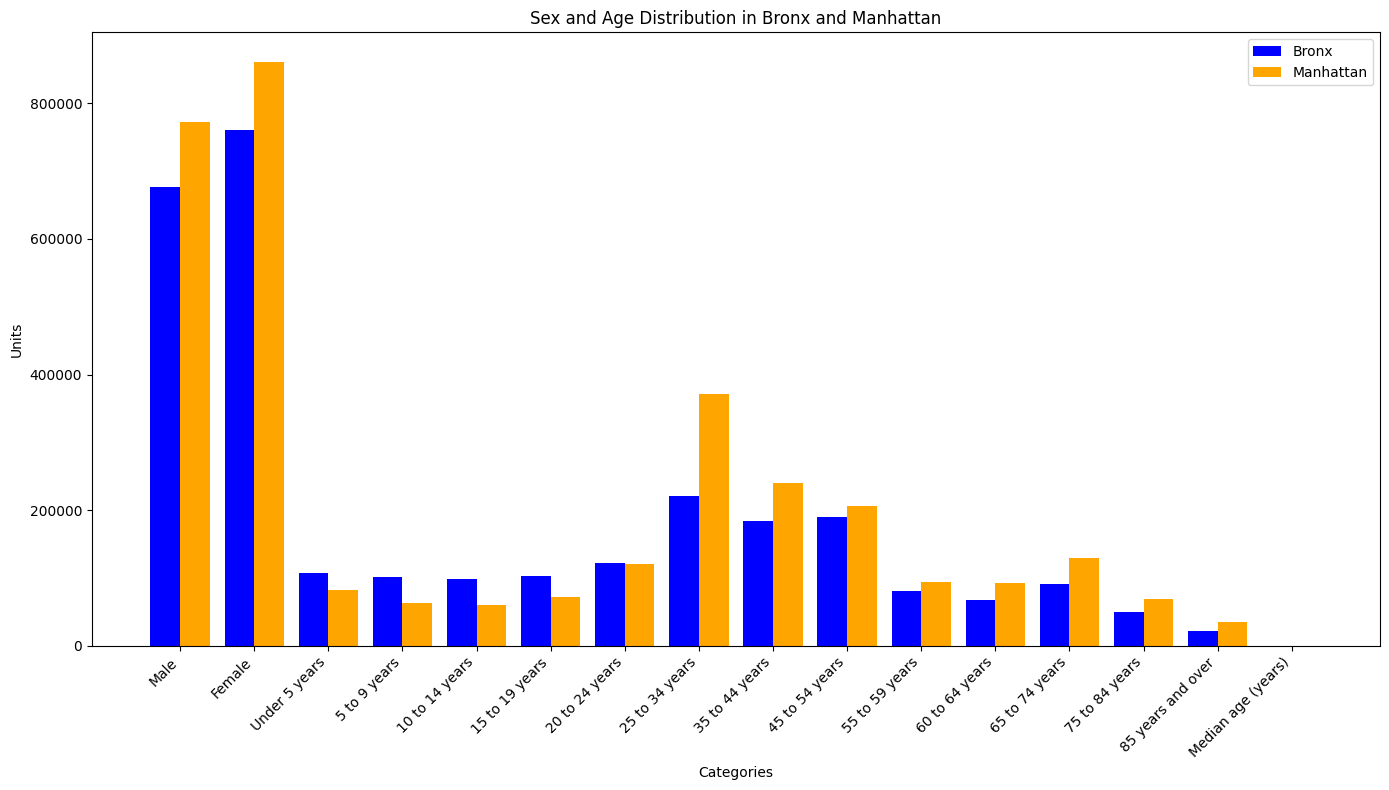

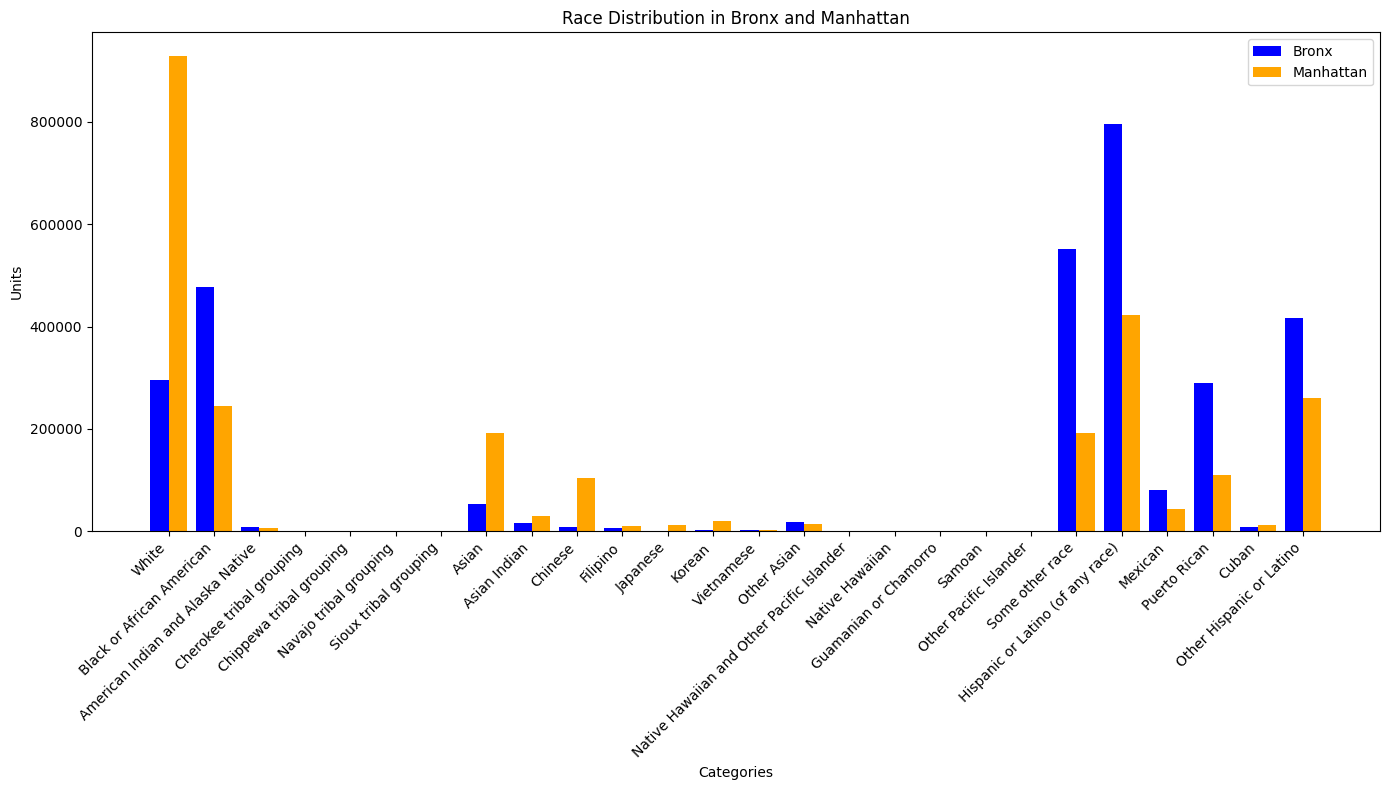

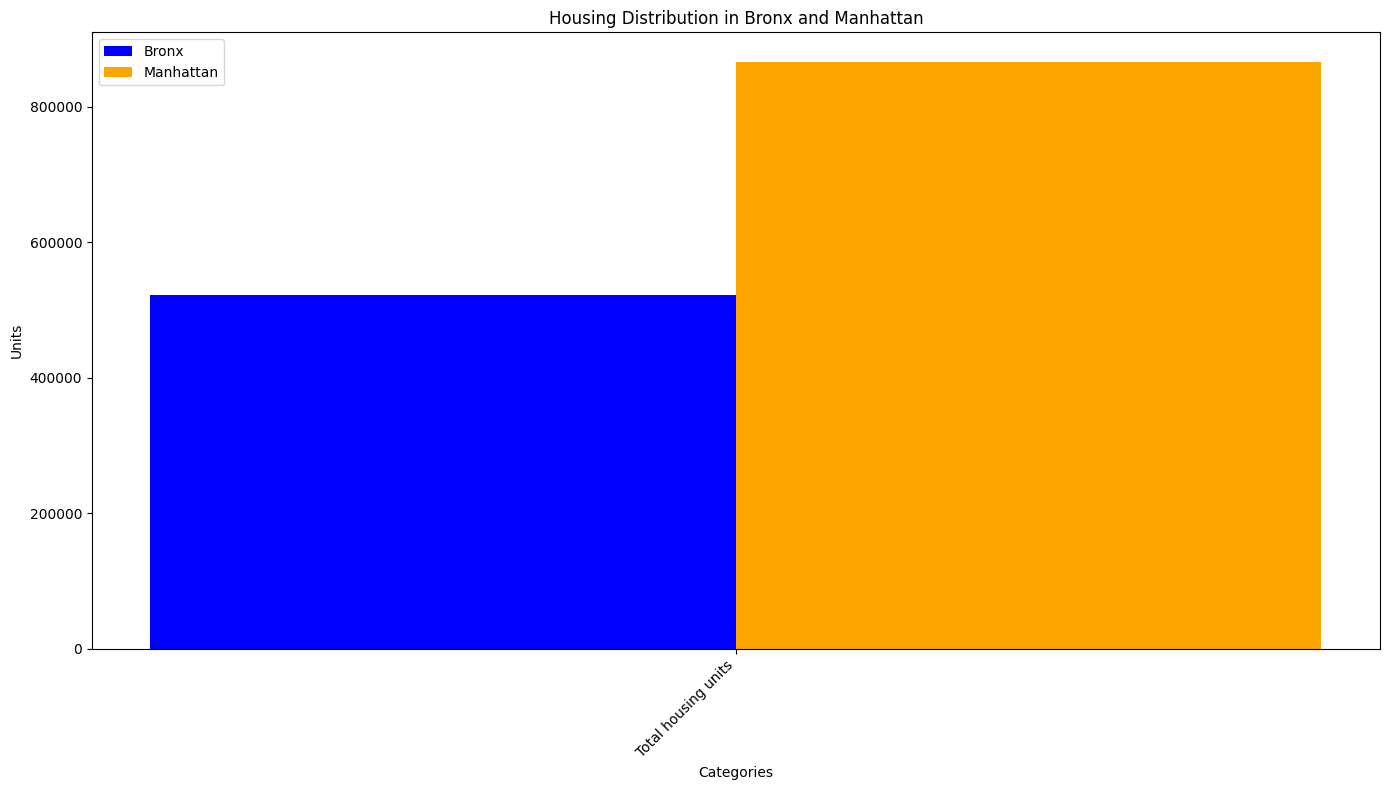

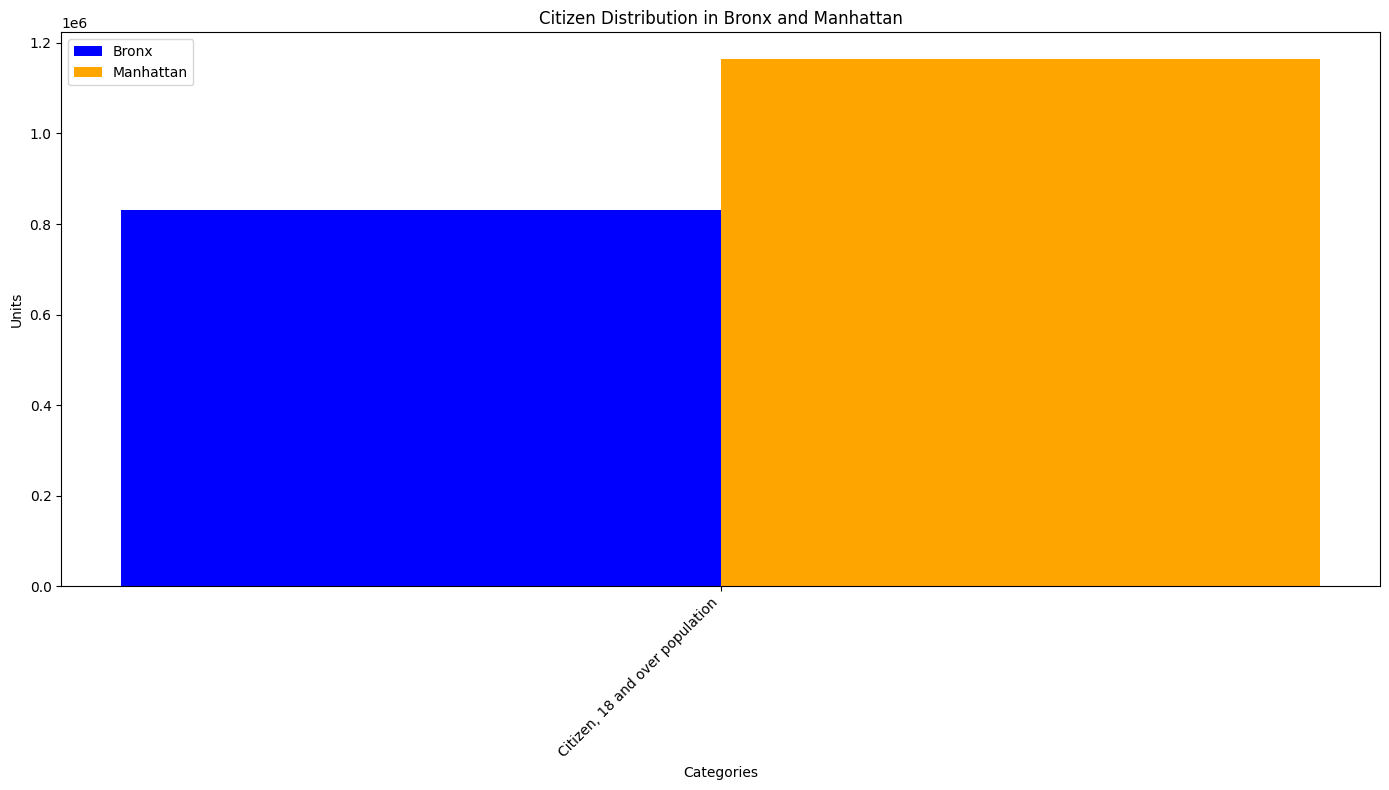

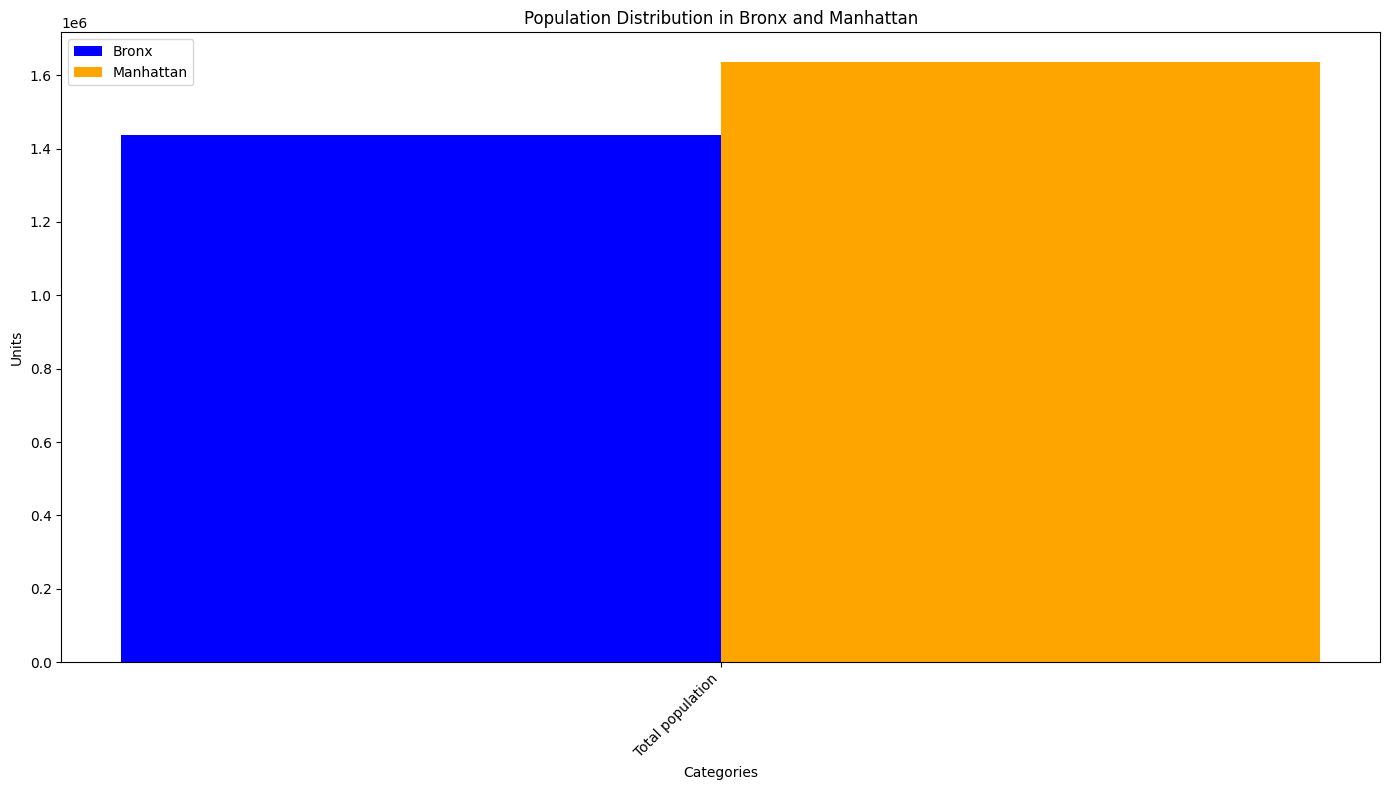

In [129]:
# Plotting the Bronx and Manhattan sex and age data
plot_distribution(bronx_sex_age, manhattan_sex_age, 'Sex and Age Distribution in Bronx and Manhattan')
# Plotting the Bronx and Manhattan race data
plot_distribution(bronx_race, manhattan_race, 'Race Distribution in Bronx and Manhattan')
# Plotting the Bronx and Manhattan housing data
plot_distribution(bronx_housing, manhattan_housing, 'Housing Distribution in Bronx and Manhattan')
# Plotting the Bronx and Manhattan citizen data
plot_distribution(bronx_citizen, manhattan_citizen, 'Citizen Distribution in Bronx and Manhattan')
# Plotting the Bronx and Manhattan population data
plot_distribution(bronx_population, manhattan_population, 'Population Distribution in Bronx and Manhattan')

Things to note about the demographics:
1. More females than males for both counties in New York. 
2. Manhattan has typically more people than the Bronx.
3. About 75% of Manhattan's population are Citizens 18 years and older, while the Bronx is only at about 57%. 
4. There are almost 300,000 more total housing units in Manhattan compared to the Bronx.
5. Manhattan's population is generally older than the Bronx.
6. Manhattan's population is primarily white or asian, while the Bronx is primarily african american or latin american.

### Economic Data:

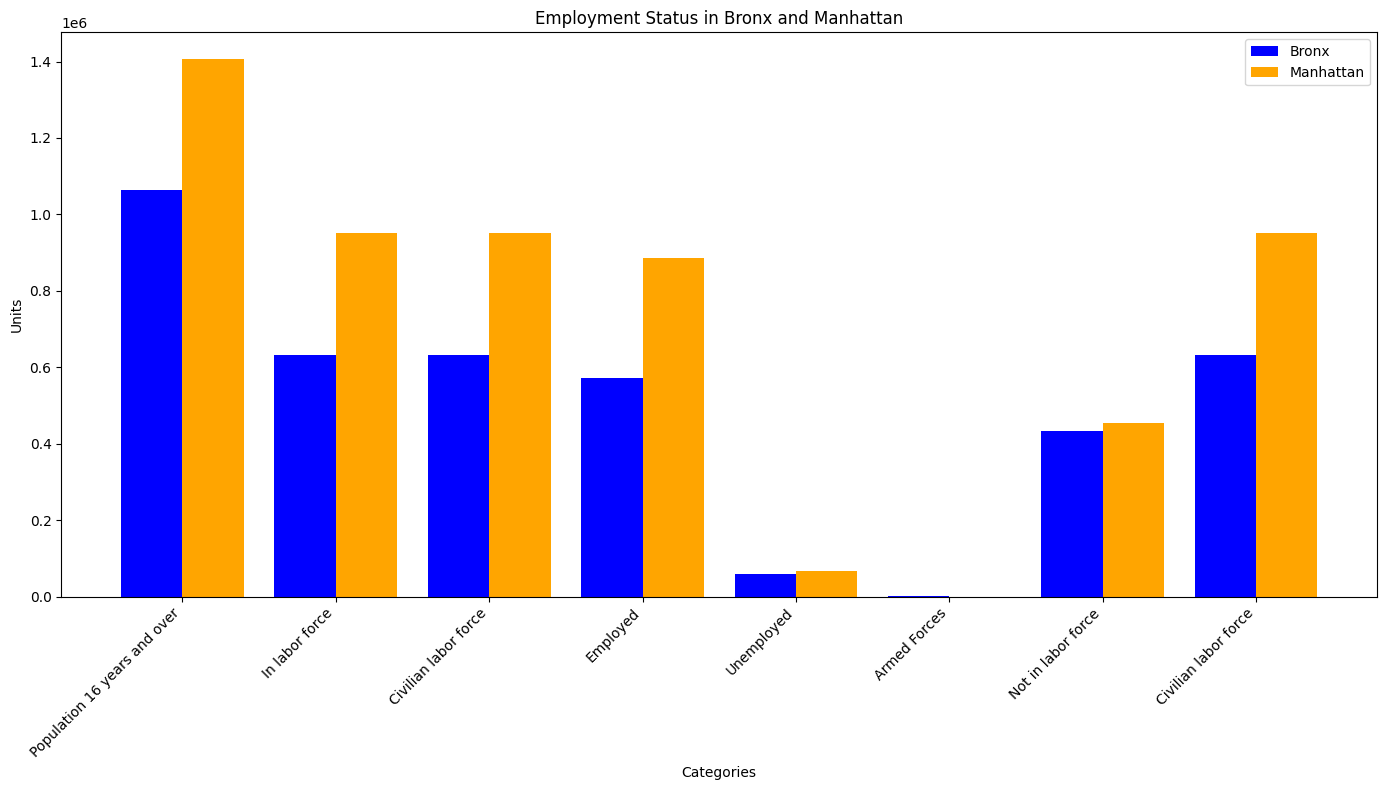

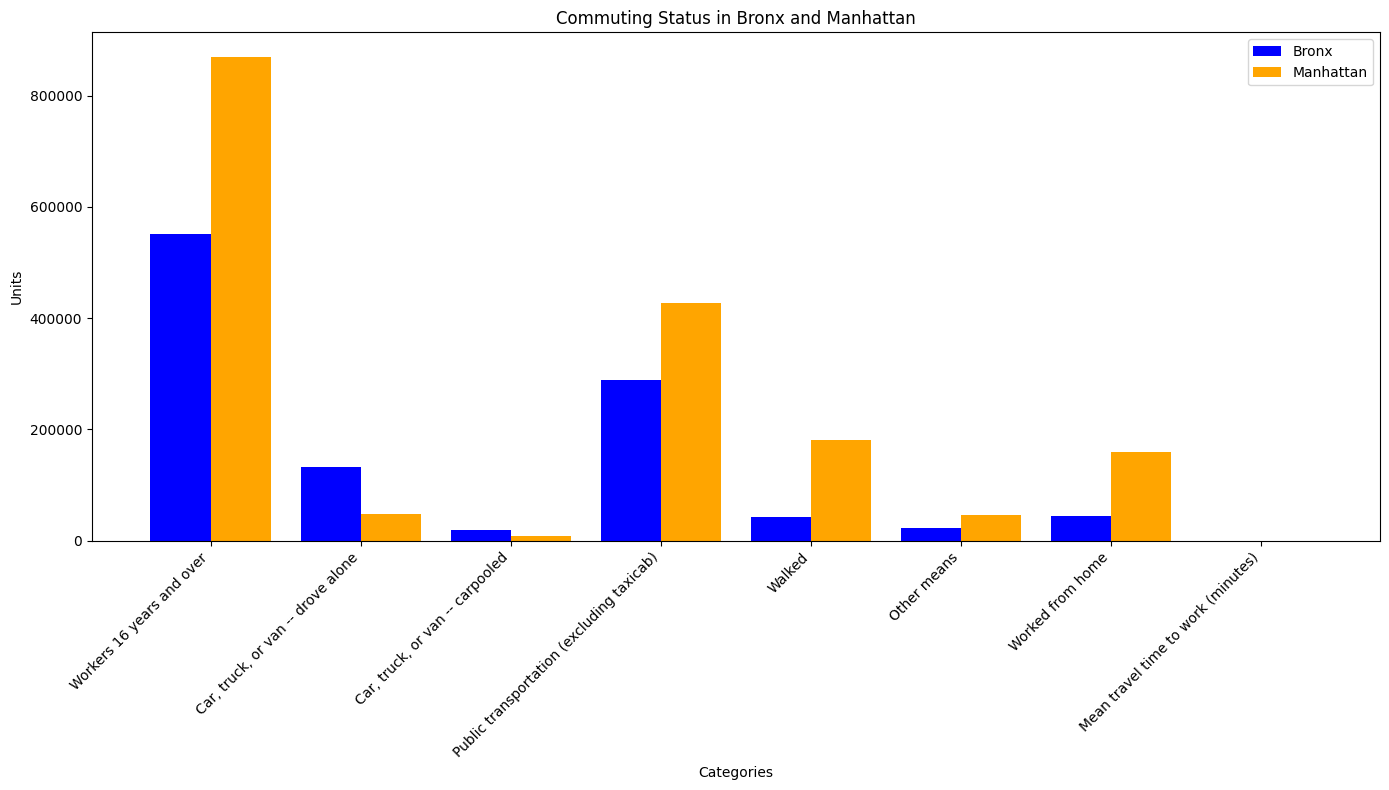

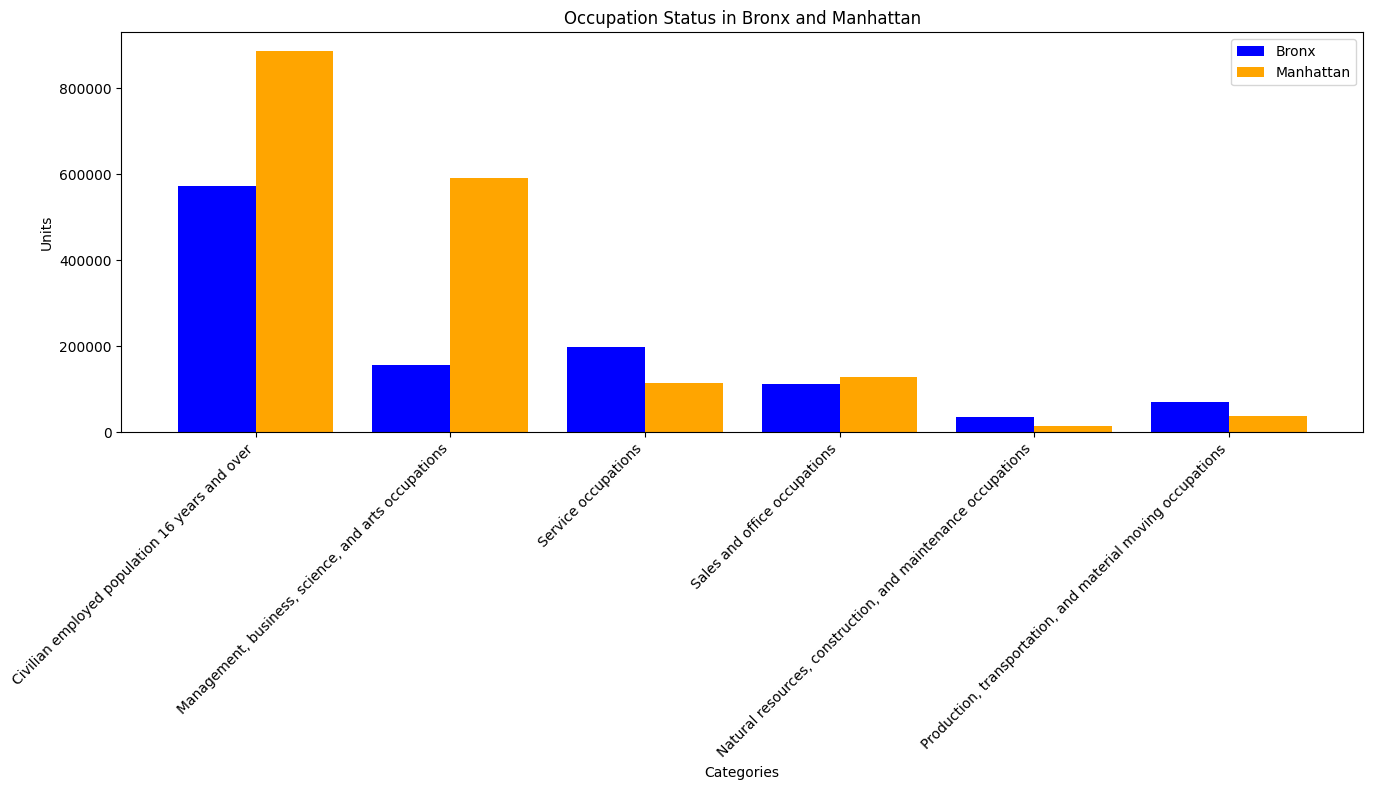

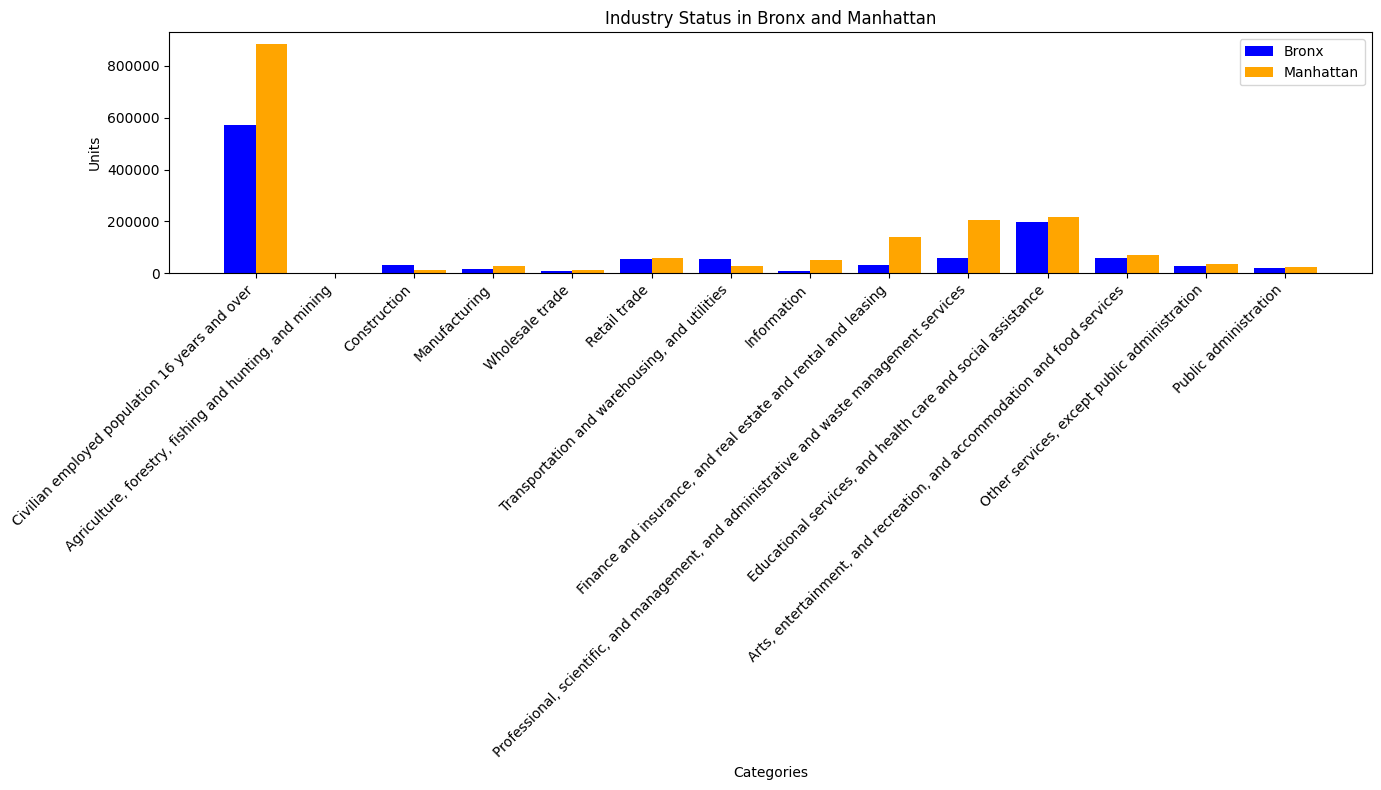

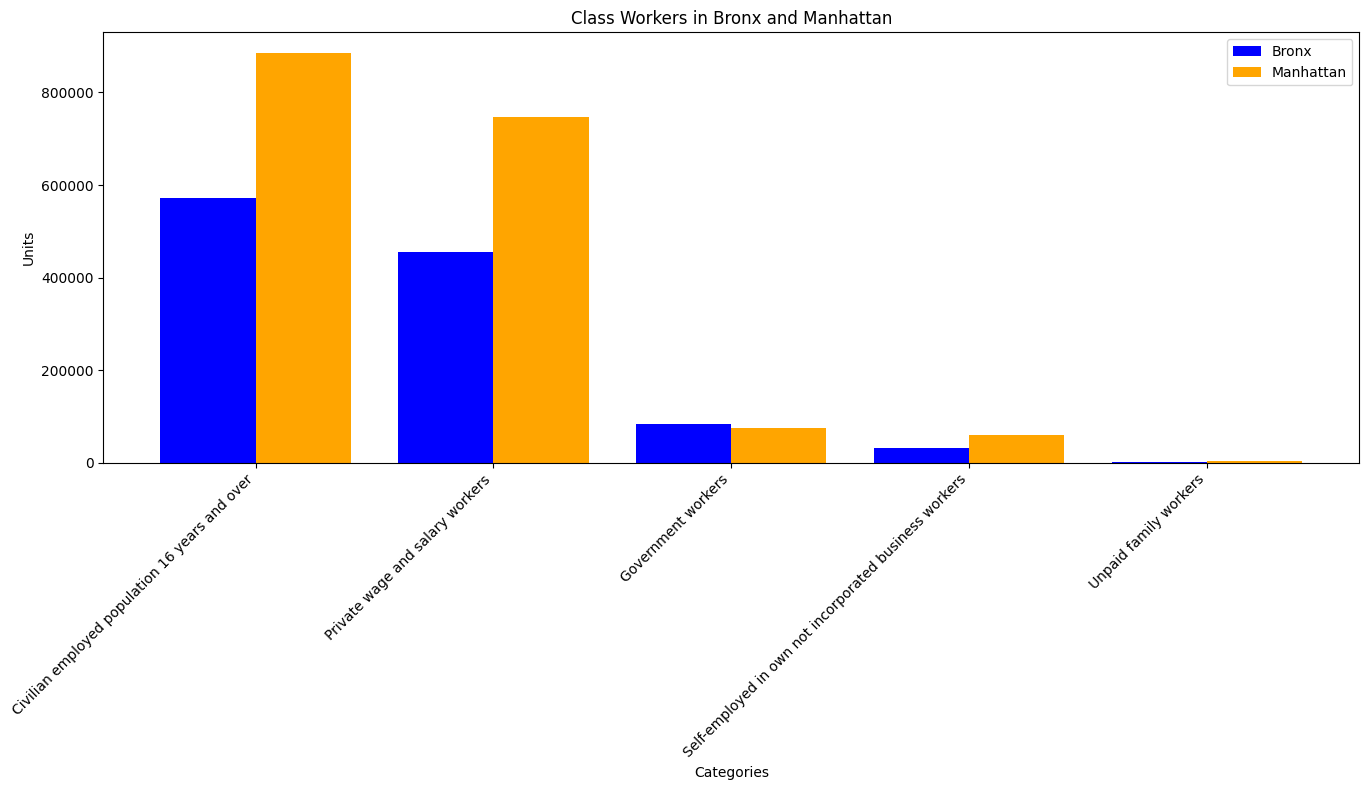

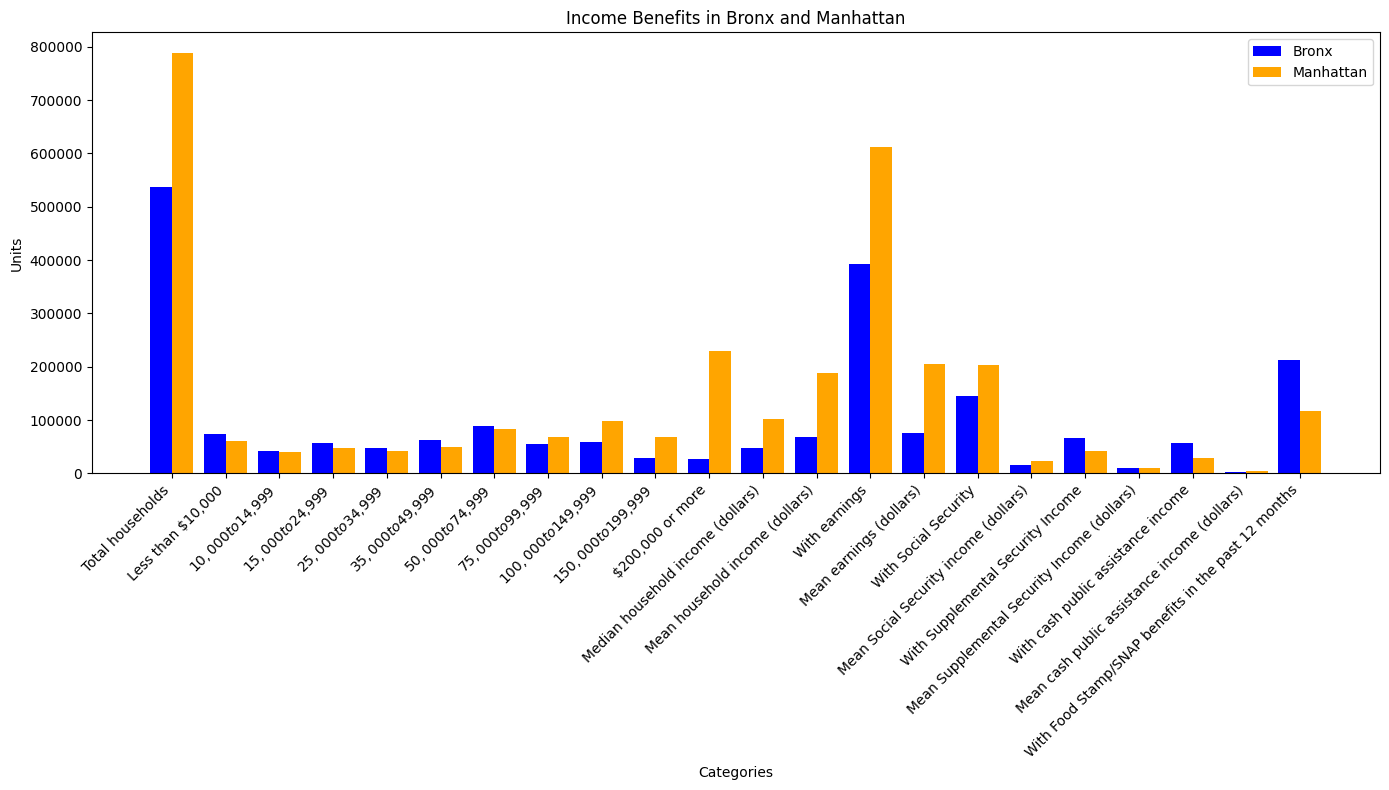

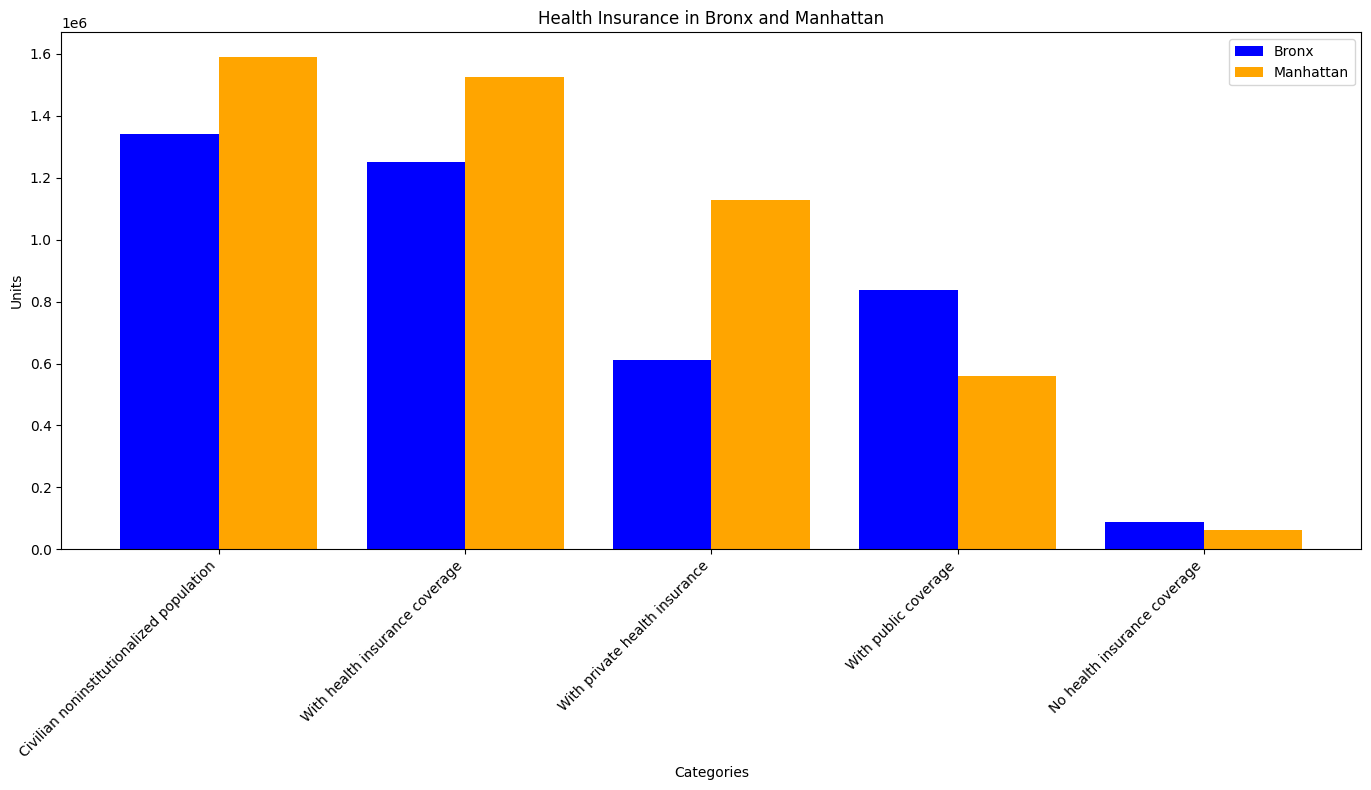

In [130]:
# Plotting the Bronx and Manhattan employment data
plot_distribution(bronx_employment_status, manhattan_employment_status, 'Employment Status in Bronx and Manhattan')
# Plotting the Bronx and Manhattan commuting data
plot_distribution(bronx_commuting_status, manhattan_commuting_status, 'Commuting Status in Bronx and Manhattan')
# Plotting the Bronx and Manhattan occupation data
plot_distribution(bronx_occupation_status, manhattan_occupation_status, 'Occupation Status in Bronx and Manhattan')
# Plotting the Bronx and Manhattan industry data\
plot_distribution(bronx_industry_status, manhattan_industry_status, 'Industry Status in Bronx and Manhattan')
# Plotting the Bronx and Manhattan class data
plot_distribution(bronx_class_workers, manhattan_class_workers, 'Class Workers in Bronx and Manhattan')
# Plotting the Bronx and Manhattan income data
plot_distribution(bronx_income_benefits, manhattan_income_benefits, 'Income Benefits in Bronx and Manhattan')
# Plotting the Bronx and Manhattan health insurance data
plot_distribution(bronx_health_insurance, manhattan_health_insurance, 'Health Insurance in Bronx and Manhattan')


Things to note about the economics:
1. Manhattan has more individuals in the labor force, but about the same unemployed as the Bronx.
2. The Bronx has less people using public transportation or walking compared to Manhattan. However, the Bronx has more individuals carpooling or driving alone. 
3. There are an significantly more Manhattan workers that are in management positions compared to the Bronx. The Bronx has more people involved in general service, sales, and construction occupations. 
4. Manhattan has more workers in industries relating to finance and management, while the numbers are more evenly spread across other industries. Typically, these other industries are less paying.
5. There are more salary workers in Manhattan rather than the Bronx.
6. The Bronx population is more predominantly in lower income amounts, while the Manhattan population dominates higher income amounts above 100,000. 
7. The mean household income in Manhattan is over double the Bronx.

# Clustering:

Build out two clusters of data relating to the socioeconomic implications for Manhattan versus Bronx.

We are hoping to cluster points by their groups of location within a certain area. This is based on the avearges, zip codes, or other features.  

Actual elevation by a certain cluster that pulls the average height of that cluster for the model in different areas.